In [1]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt                                                 
import seaborn as sns 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from prettytable import PrettyTable

import warnings
warnings.filterwarnings("ignore")
# Loading the data
sensor_data = pd.read_csv('pump_sensor.csv')

# Encoding labels as 0 and 1
sensor_data['label'] = sensor_data['machine_status'].map(lambda label: 0 if label == 'NORMAL' else 1)

def shift_labels(sensor_list, df):
    """
    Function to shift labels by 10 min
    """
    new_features = {}

    for sensor in sensor_list:
        new_features[sensor] = df[sensor]

    labels = [None] * df.shape[0]

    for i in range(0, df.shape[0]-10):
        labels[i] = df['label'][i+10]

    new_features['label'] = labels
    new_df = pd.DataFrame(new_features)
    # Dropping last rows with null value
    new_df.drop(new_df.tail(10).index, inplace=True)
    return new_df

data_10min_shift = shift_labels(sensor_data.columns[1:-1], sensor_data)

final_sensors = ['sensor_00', 'sensor_04', 'sensor_06', 'sensor_07',
                 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11',
                 'sensor_12', 'sensor_13', 'sensor_48', 'sensor_49',
                 'sensor_01', 'sensor_38', 'sensor_07', 'sensor_40',
                 'sensor_03', 'sensor_46', 'sensor_36', 'sensor_02', 'sensor_45']

def get_new_features(sensor_list, df):
    """
    Function to find distance from normal state mean value
    """
    new_features = {}
    for sensor in sensor_list:
        normal_values = df[df['label'] == 0][sensor].values
        normal_mean = np.nanmean(normal_values)  # Replaced np.mean with np.nanmean
        val = df[sensor] - normal_mean
        new_features[sensor] = val
    new_features['label'] = df['label']
    new_df = pd.DataFrame(new_features)
    return new_df

# Dist from mean of normal state
df_dist_from_norm_mean = get_new_features(final_sensors, data_10min_shift)
df_dist_from_norm_mean.head()


,sensor_00,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,...,sensor_49,sensor_01,sensor_38,sensor_40,sensor_03,sensor_46,sensor_36,sensor_02,sensor_45,label
0,0.045317,8.768746,-0.45303,-0.034304,0.089097,-0.033044,-7.032865,2.765787,-0.047991,-5.889199,...,9.134302,-1.087666,-10.283594,-0.38201,2.144083,2.069046,-399.487273,1.576566,21.898167,0.0
1,0.045317,8.768746,-0.45303,-0.034304,0.089097,-0.033044,-7.032865,2.765787,-0.047991,-5.889199,...,9.134302,-1.087666,-10.283594,-0.38201,2.144083,2.069046,-399.487273,1.576566,21.898167,0.0
2,0.024657,13.282646,-0.53984,-0.128334,0.139737,-0.076444,-6.392495,3.418797,0.923789,-5.862078,...,8.555592,-0.827246,-9.241924,-1.42367,2.230893,2.358396,-393.583373,1.576566,21.608817,0.0
3,0.040397,2.518746,-0.54707,0.081446,0.219307,-0.004104,-5.680495,3.897637,0.507059,-5.991125,...,8.266242,-1.087666,-8.721094,1.18049,2.230891,2.358396,-401.383873,1.533166,21.030107,0.0
4,0.025641,10.852046,-0.51090,0.045276,0.219307,-0.004104,-4.770875,4.304547,0.786869,-5.886721,...,7.976892,-1.044266,-7.939844,5.86799,2.230891,2.937096,-400.675773,1.576566,21.319457,0.0


In [2]:
import pandas as pd

# Calculate Motor Frequency Avg
sensor_data['Motor_Frequency_Aveg'] = (sensor_data['sensor_01'] + sensor_data['sensor_02'] + sensor_data['sensor_03'])/3

# Calculate Motor Power Factor
sensor_data['Motor_Power_Factor'] = sensor_data['sensor_06'] / sensor_data['sensor_07']

# Calculate Motor Efficiency
sensor_data['Motor_Efficiency'] = sensor_data['sensor_09'] / sensor_data['sensor_07']

# Calculate Motor Unbalance
sensor_data['Motor_Unbalance'] = sensor_data[['sensor_10', 'sensor_11', 'sensor_12']].std(axis=1)

# Calculate Motor Voltage Imbalance
sensor_data['Motor_Voltage_Imbalance'] = sensor_data[['sensor_14', 'sensor_16', 'sensor_17']].max(axis=1) - sensor_data[['sensor_14', 'sensor_16', 'sensor_17']].min(axis=1)

# Calculate Pump Temperature Differential
sensor_data['Pump_Temperature_Differential'] = sensor_data['sensor_46'] - sensor_data['sensor_45']

# Calculate Pump Pressure Differential
sensor_data['Pump_Pressure_Differential'] = sensor_data['sensor_50'] - sensor_data['sensor_48']

# Filter the selected features and label
final_features = final_sensors + ['Motor_Frequency_Aveg', 'Motor_Power_Factor', 'Motor_Efficiency', 'Motor_Unbalance',
                                  'Motor_Voltage_Imbalance', 'Pump_Temperature_Differential', 'Pump_Pressure_Differential', 'label']

df_dist_from_norm_mean = sensor_data[final_features].copy()


In [3]:
df_dist_from_norm_mean.shape

(220320, 29)

In [4]:
# y data
data_y = df_dist_from_norm_mean['label']
# x data
data_x = df_dist_from_norm_mean.drop(columns='label')

train_dataPoints = 131000

X_train = data_x[:train_dataPoints]
y_train = data_y[:train_dataPoints]

X_test = data_x[train_dataPoints: ]
y_test = data_y[train_dataPoints: ]

In [5]:
def normalize_df(df_train, df_test):
    """
    Function to normalize the data using MinMaxScaler
    """
    # Handle missing values
    df_train.fillna(0, inplace=True)
    df_test.fillna(0, inplace=True)
    
    # Handle extreme values
    max_threshold = 1e9  # Adjust this threshold based on your data
    df_train = df_train.clip(lower=-max_threshold, upper=max_threshold)
    df_test = df_test.clip(lower=-max_threshold, upper=max_threshold)

    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(df_train.values)
    scaled_test = scaler.transform(df_test.values)
    train = pd.DataFrame(data=scaled_train,
                         columns=df_train.columns,
                         index=df_train.index)
    test = pd.DataFrame(data=scaled_test,
                        columns=df_test.columns,
                        index=df_test.index)
    return train, test

X_train, X_test = normalize_df(X_train, X_test)

In [6]:
X_train, X_test = normalize_df(X_train, X_test)

In [8]:
X_train.head()

,sensor_00,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,...,sensor_36,sensor_02,sensor_45,Motor_Frequency_Aveg,Motor_Power_Factor,Motor_Efficiency,Motor_Unbalance,Motor_Voltage_Imbalance,Pump_Temperature_Differential,Pump_Pressure_Differential
0,0.967194,0.792969,0.602731,0.686154,0.667908,0.675211,0.489146,0.792070,0.691492,0.053911,...,0.198225,0.949651,0.298292,0.931348,8.313905e-10,9.331842e-10,0.230031,0.065976,0.189312,0.639397
1,0.967194,0.792969,0.602731,0.686154,0.667908,0.675211,0.489146,0.792070,0.691492,0.053911,...,0.198225,0.949651,0.298292,0.931348,8.313905e-10,9.331842e-10,0.230031,0.065976,0.189312,0.639397
2,0.959089,0.798611,0.598829,0.682154,0.670081,0.673264,0.497561,0.802954,0.713088,0.054781,...,0.204225,0.949651,0.296978,0.933554,8.308521e-10,9.359494e-10,0.226083,0.059172,0.191123,0.640474
3,0.965264,0.785156,0.598505,0.691077,0.673495,0.676509,0.506916,0.810935,0.703827,0.050643,...,0.196298,0.948877,0.294349,0.931624,8.196793e-10,9.283171e-10,0.236938,0.059478,0.192935,0.637245
4,0.959475,0.795573,0.600130,0.689539,0.673495,0.676509,0.518868,0.817716,0.710045,0.053990,...,0.197017,0.949651,0.295664,0.932175,8.237394e-10,9.303884e-10,0.237897,0.068198,0.193841,0.635091


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(max_depth=20, n_estimators=150)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

result = np.column_stack((y_pred, y_test))


# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Random Forest Classifier Results:")
print("Accuracy:", accuracy)
print("F1 Score:", f1)

Random Forest Classifier Results:
Accuracy: 0.9990707568293775
F1 Score: 0.9924920850293985


In [16]:
# Print predicted labels and corresponding true labels
print("Test Data\tPredicted Label\tTrue Label")
for i in range(len(X_test)):
    if y_pred[i] != y_test.iloc[i]:
        print(f"{X_test.iloc[i]}\t{y_pred[i]}\t\t{y_test.iloc[i]}")

Test Data	Predicted Label	True Label
sensor_00                        1.200309e-01
sensor_04                        1.537653e-01
sensor_06                        5.087775e-01
sensor_07                        5.369228e-01
sensor_08                        5.450033e-01
sensor_09                        5.648930e-01
sensor_10                        1.617888e-02
sensor_11                        0.000000e+00
sensor_12                        0.000000e+00
sensor_13                        0.000000e+00
sensor_48                        6.912442e-02
sensor_49                        1.002686e-01
sensor_01                        7.789883e-01
sensor_38                        9.878904e-02
sensor_07                        5.369228e-01
sensor_40                        9.954291e-02
sensor_03                        8.505851e-01
sensor_46                        1.118124e-01
sensor_36                        5.972694e-01
sensor_02                        6.808675e-01
sensor_45                        1.471747e-

sensor_00                        8.282518e-01
sensor_04                        3.880932e-03
sensor_06                        1.397919e-01
sensor_07                        6.876920e-01
sensor_08                        6.750467e-01
sensor_09                        6.765090e-01
sensor_10                        3.973354e-01
sensor_11                        2.253313e-01
sensor_12                        2.132610e-01
sensor_13                        2.670399e-01
sensor_48                        4.533410e-01
sensor_49                        2.032229e-01
sensor_01                        8.217899e-01
sensor_38                        1.281071e-01
sensor_07                        6.876920e-01
sensor_40                        1.802946e-01
sensor_03                        9.090907e-01
sensor_46                        2.110009e-01
sensor_36                        8.475178e-01
sensor_02                        9.465529e-01
sensor_45                        2.378449e-01
Motor_Frequency_Aveg             9

sensor_00                        0.000000
sensor_04                        0.000000
sensor_06                        0.000000
sensor_07                        0.000000
sensor_08                        0.000000
sensor_09                        0.000000
sensor_10                        0.000000
sensor_11                        0.000000
sensor_12                        0.000000
sensor_13                        0.000000
sensor_48                        0.000000
sensor_49                        0.000000
sensor_01                        0.000000
sensor_38                        0.000000
sensor_07                        0.000000
sensor_40                        0.000000
sensor_03                        0.000000
sensor_46                        0.000000
sensor_36                        0.801711
sensor_02                        0.000000
sensor_45                        0.000000
Motor_Frequency_Aveg             0.000000
Motor_Power_Factor               0.000000
Motor_Efficiency                 0

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

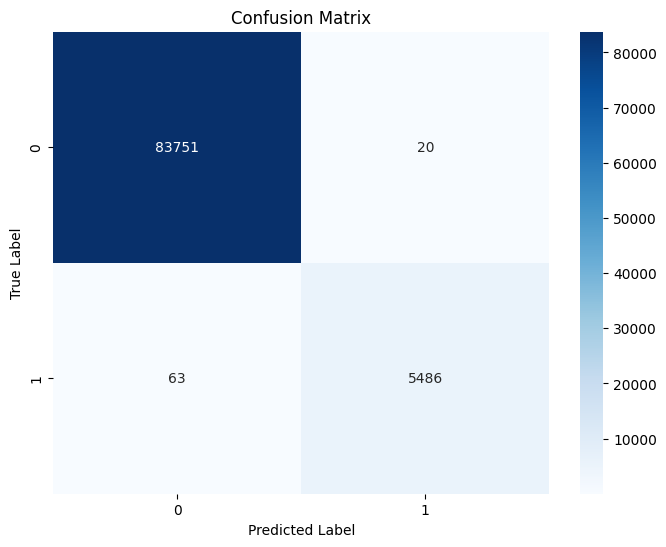

In [19]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## saving model now

In [11]:

import pickle

filename = 'trained_model_new_feature.sav'
pickle.dump(rf_classifier, open(filename, 'wb'))
# loading the saved model
loaded_model = pickle.load(open('trained_model_new_feature.sav', 'rb'))


